In [588]:
import keras.api._v2.keras as K
import tensorflow as tf
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool
from multiprocessing import cpu_count

In [589]:
BOARD_SIZE = 3

In [590]:
agent = K.models.Sequential()
agent.add(K.layers.Flatten(input_shape=(BOARD_SIZE,BOARD_SIZE,4)))
agent.add(K.layers.Dense(256, activation='selu'))
agent.add(K.layers.Dense(256, activation='selu'))
agent.add(K.layers.Dense(4, activation='softmax'))
# [up, right, bottom, left]

In [591]:
value = K.models.Sequential()
value.add(K.layers.Flatten(input_shape=(BOARD_SIZE,BOARD_SIZE,4)))
value.add(K.layers.Dense(256, activation='selu'))
value.add(K.layers.Dense(256, activation='selu'))
value.add(K.layers.Dense(1, activation='linear'))

In [592]:
class Environment:
    def __init__(self, n_boards, board_size):
        self.UP = 0
        self.RIGHT = 1
        self.DOWN = 2
        self.LEFT = 3

        self.WIN_REWARD = 10000
        self.FRUIT_REWARD = 10
        self.STEP_REWARD = -1
        self.ATE_HIMSELF_REWARD = 10 # scalar to multiply to -len(eaten body)

        self.HEAD = 3
        self.BODY = 2
        self.FRUIT = 1
        self.EMPTY = 0

        self.board_size = board_size
        self.n_boards = n_boards
        self.boards = np.zeros((self.n_boards, self.board_size, self.board_size))
        for board in self.boards:
            i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
            board[i,j] = self.HEAD
            while board[i,j] != 0:
                i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
            board[i,j] = self.FRUIT
        self.bodies = [[] for _ in range(self.n_boards)]
    def move(self, actions):
        rewards = [0] * self.n_boards
        def process_board(elems):
            board_count, (board, action, body) = elems
            if tf.reduce_sum(board) - 5 == (self.board_size**2 - 3) * self.BODY:
                print("won")
                rewards[board_count] = self.WIN_REWARD
                board = np.zeros(self.board_size, self.board_size)
                i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.HEAD
                while board[i,j] != 0:
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.FRUIT
                del body[:]

            dx = 0; dy = 0
            if action in [self.UP,self.DOWN]:
                dx = 1 if action == self.UP else -1
            if action in [self.RIGHT,self.LEFT]:
                dy = 1 if action == self.RIGHT else -1
            head = tf.cast(tf.where(board == self.HEAD)[0], dtype=tf.int32)
            fruit = tf.cast(tf.where(board == self.FRUIT)[0], dtype=tf.int32)

            body.insert(0, head)
            board[tuple(head.numpy())] = self.BODY

            # eat fruit
            if tf.reduce_all(tf.equal(head + [dx, dy], fruit)):
                board[tuple(fruit.numpy())] = self.EMPTY
                i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                while board[i,j] != 0 and tf.reduce_all(tf.equal(head + [dx, dy], [i,j])):
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.FRUIT
                rewards[board_count] = self.FRUIT_REWARD
            # he eats himself
            elif tf.reduce_any(tf.reduce_all(tf.equal(body, tf.repeat(tf.expand_dims(head + [dx, dy], axis=0), len(body), axis=0)), axis=-1)):
                since = tf.where(tf.reduce_all(tf.equal(body, tf.repeat(tf.expand_dims(head + [dx, dy], axis=0), len(body), axis=0)), axis=-1))[0,0]
                pieces_eaten = len(body) - since
                for pos in body[since:]:
                    board[tuple(pos)] = self.EMPTY
                del body[since:]
                position = body.pop()
                board[tuple(position.numpy())] = self.EMPTY
                rewards[board_count] = -pieces_eaten * self.ATE_HIMSELF_REWARD
            # doesn't eat fruit
            else:
                position = body.pop()
                board[tuple(position.numpy())] = self.EMPTY
                rewards[board_count] = self.STEP_REWARD

            board[tuple(head + [dx, dy])] = self.HEAD

            if tf.size(tf.where(board == self.FRUIT)) == 0:
                # probably better to check the indexes where the board is free and pick one at random
                i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                while board[i,j] != 0:
                    i = np.random.randint(0,self.board_size); j = np.random.randint(0,self.board_size)
                board[i,j] = self.FRUIT

        with Pool(cpu_count()) as p:
            _ = p.map(process_board, enumerate(zip(self.boards, actions, self.bodies)))
        return tf.reshape(tf.convert_to_tensor(rewards, dtype=tf.float32), (-1,1))

In [593]:
#%matplotlib inline
#env = Environment(1,5)

In [594]:
#plt.imshow(env.boards[0], origin="lower")

In [595]:
#env.move(tf.convert_to_tensor([[env.LEFT]]))

In [596]:
def re_normalize_possible_actions(state, probs, mask_with=np.finfo(np.float32).min):
    state = tf.argmax(state, axis=-1)
    indexes = tf.where(state == 3)
    mask = np.ones_like(probs)

    # [up, right, bottom, left]
    left_border = tf.where(indexes[:,2] == 0)
    left_border = tf.concat((left_border, tf.ones_like(left_border)*3), axis=-1)
    mask = tf.tensor_scatter_nd_update(mask, left_border, mask_with * tf.ones(left_border.shape[0]))

    right_border = tf.where(indexes[:,2] == BOARD_SIZE-1)
    right_border = tf.concat((right_border, tf.ones_like(right_border)*1), axis=-1)
    mask = tf.tensor_scatter_nd_update(mask, right_border, mask_with * tf.ones(right_border.shape[0]))


    top_border = tf.where(indexes[:,1] == BOARD_SIZE-1)
    top_border = tf.concat((top_border, tf.ones_like(top_border)*0), axis=-1)
    mask = tf.tensor_scatter_nd_update(mask, top_border, mask_with * tf.ones(top_border.shape[0]))

    bottom_border = tf.where(indexes[:,1] == 0)
    bottom_border = tf.concat((bottom_border, tf.ones_like(bottom_border)*2), axis=-1)
    mask = tf.tensor_scatter_nd_update(mask, bottom_border, mask_with * tf.ones(bottom_border.shape[0]))
    return tf.nn.softmax(probs * tf.stop_gradient(mask))

In [597]:
optimizer_value = K.optimizers.Adam(1e-3)
optimizer_agent = K.optimizers.Adam(1e-4)

In [598]:
# %load_ext line_profiler
# %lprun -f simulate

In [599]:
env_ = Environment(100, BOARD_SIZE)
GAMMA = .9

In [600]:
avg_rewards = []
for iter in trange(10000):
    state = K.utils.to_categorical(env_.boards)
    try:
        if iter % 100 == 0:
            agent.save_weights(f"weights/agent_{iter}")
            value.save_weights(f"weights/value_{iter}")

        with tf.GradientTape(persistent=True) as tape:
            original_probs = agent(
                state
            )
            probs = re_normalize_possible_actions(
                state,
                original_probs
            )
            actions =  tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)

            rewards = env_.move(actions)
            new_state = K.utils.to_categorical(env_.boards)

            value_state = value(state)
            td_error = tf.stop_gradient((rewards + GAMMA * value(new_state, training=False)) - value_state) * -1 # to do gradient ascend

            actions_indexes = tf.concat((tf.range(actions.shape[0])[...,None] , actions), axis=-1)
            loss_agent = tf.stop_gradient(td_error) * tf.math.log(tf.gather_nd(probs, actions_indexes))
            loss_value = tf.stop_gradient(td_error) * value_state

        gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
        gradient_value = tape.gradient(loss_value, value.trainable_weights)
        avg_rewards.append(tf.reduce_mean(rewards))

        optimizer_agent.apply_gradients(zip(gradient_agent, agent.trainable_weights))
        optimizer_value.apply_gradients(zip(gradient_value, value.trainable_weights))
    except Exception as e:
        print(e)
        print("Resetting env")
        env_ = Environment(1000, BOARD_SIZE)

100%|██████████| 10000/10000 [56:31<00:00,  2.95it/s]


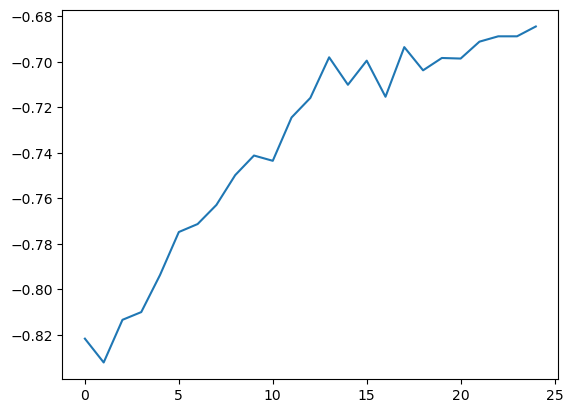

In [608]:
%matplotlib inline
plt.plot(np.array(avg_rewards).reshape((-1,400)).mean(axis=-1))

In [603]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [604]:
test_env = Environment(10,BOARD_SIZE)

In [605]:
def animate(_):
    state = K.utils.to_categorical(test_env.boards)
    original_probs = agent(
        state
    )
    probs = re_normalize_possible_actions(
        state,
        original_probs
    )
    log_probs = tf.math.log(tf.stop_gradient(probs))
    actions =  tf.random.categorical(log_probs, 1, dtype=tf.int32)
    test_env.move(actions)
    image.set_data(test_env.boards[0])
    return image

In [606]:
fig = plt.figure()
image = plt.imshow(test_env.boards[0], origin="lower")
anim = FuncAnimation(fig, animate, frames=3,
                     interval=10)

<IPython.core.display.Javascript object>